In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
outdir='images'
import os
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
sequence_length = None#100
embed_dim = 64
num_heads = 8
projection_dim = embed_dim // num_heads

In [4]:
# Split heads
def split_heads(x):
    batch_size = tf.shape(x)[0]
    x = tf.reshape(x, (batch_size, -1, num_heads, projection_dim))
    return tf.transpose(x, perm=[0, 2, 1, 3])

tf.reshape: 입력 텐서의 형상을 (batch_size, sequence_length, num_heads, projection_dim)으로 변경합니다. 이때 sequence_length는 -1로 지정되어 있어, 나머지 차원을 기반으로 자동 계산됩니다.

tf.transpose: 이 함수를 사용하여 두 번째와 세 번째 차원을 교환하여 결과적으로 형상이 (batch_size, num_heads, sequence_length, projection_dim)이 되도록 합니다.

When you perform the split_heads operation on a tensor with shape (None, 100, 64), it results in the shape (None, 8, None, 8) because the function is designed to divide the last dimension (64 in this case) into num_heads (8 in this setting). Thus, the embedding dimension (64) is split into 8 chunks of size 8 each. The sequence length (100) remains unchanged and is represented by the None in the third dimension of the resultant shape. This reshaping allows the model to process information through 8 separate attention heads, each considering a slice of the embedding dimension.

In [5]:
#from transformer import MultiHeadSelfAttention

In [6]:
# Layers for the MHSA
query_dense = layers.Dense(embed_dim, name="query_dense")
key_dense = layers.Dense(embed_dim, name="key_dense")
value_dense = layers.Dense(embed_dim, name="value_dense")
#combine_heads = layers.Dense(embed_dim, name="combine_heads")
combine_heads = layers.Dense(embed_dim, name="combine_heads_dense")
# Input
#input_tensor = tf.keras.Input(shape=(None, embed_dim), name="Input")

input_tensor = tf.keras.Input(shape=(sequence_length, embed_dim), name="Input")

query = query_dense(input_tensor)
key = key_dense(input_tensor)
value = value_dense(input_tensor)

query = tf.keras.layers.Lambda(split_heads, name="split_heads_query")(query)
key = tf.keras.layers.Lambda(split_heads, name="split_heads_key")(key)
value = tf.keras.layers.Lambda(split_heads, name="split_heads_value")(value)

# Scaled Dot-Product Attention
score = tf.keras.layers.Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True), name="dot_product")([query, key])
scaled_score = tf.keras.layers.Lambda(lambda x: x / tf.math.sqrt(tf.cast(projection_dim, tf.float32)), name="scale")(score)
weights = tf.keras.layers.Softmax(axis=-1, name="softmax")(scaled_score)
attention = tf.keras.layers.Lambda(lambda x: tf.matmul(x[0], x[1]), name="apply_weights")([weights, value])

# Combine heads
def combine_heads_func(x):
    batch_size = tf.shape(x)[0]
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    return tf.reshape(x, (batch_size, -1, embed_dim))

combined_attention = tf.keras.layers.Lambda(combine_heads_func, name="combine_heads")(attention)
output = combine_heads(combined_attention)


In [7]:
def plot_model_custom_dpi(model, filename, dpi=300):
    import pydot
    # Create the dot object
    dot = tf.keras.utils.model_to_dot(model, show_shapes=True)
    
    # Modify the dot object to set DPI
    graph = pydot.graph_from_dot_data(dot.to_string())
    graph[0].set_dpi(dpi)
    
    # Write the modified dot object to a file
    graph[0].write_png(filename)

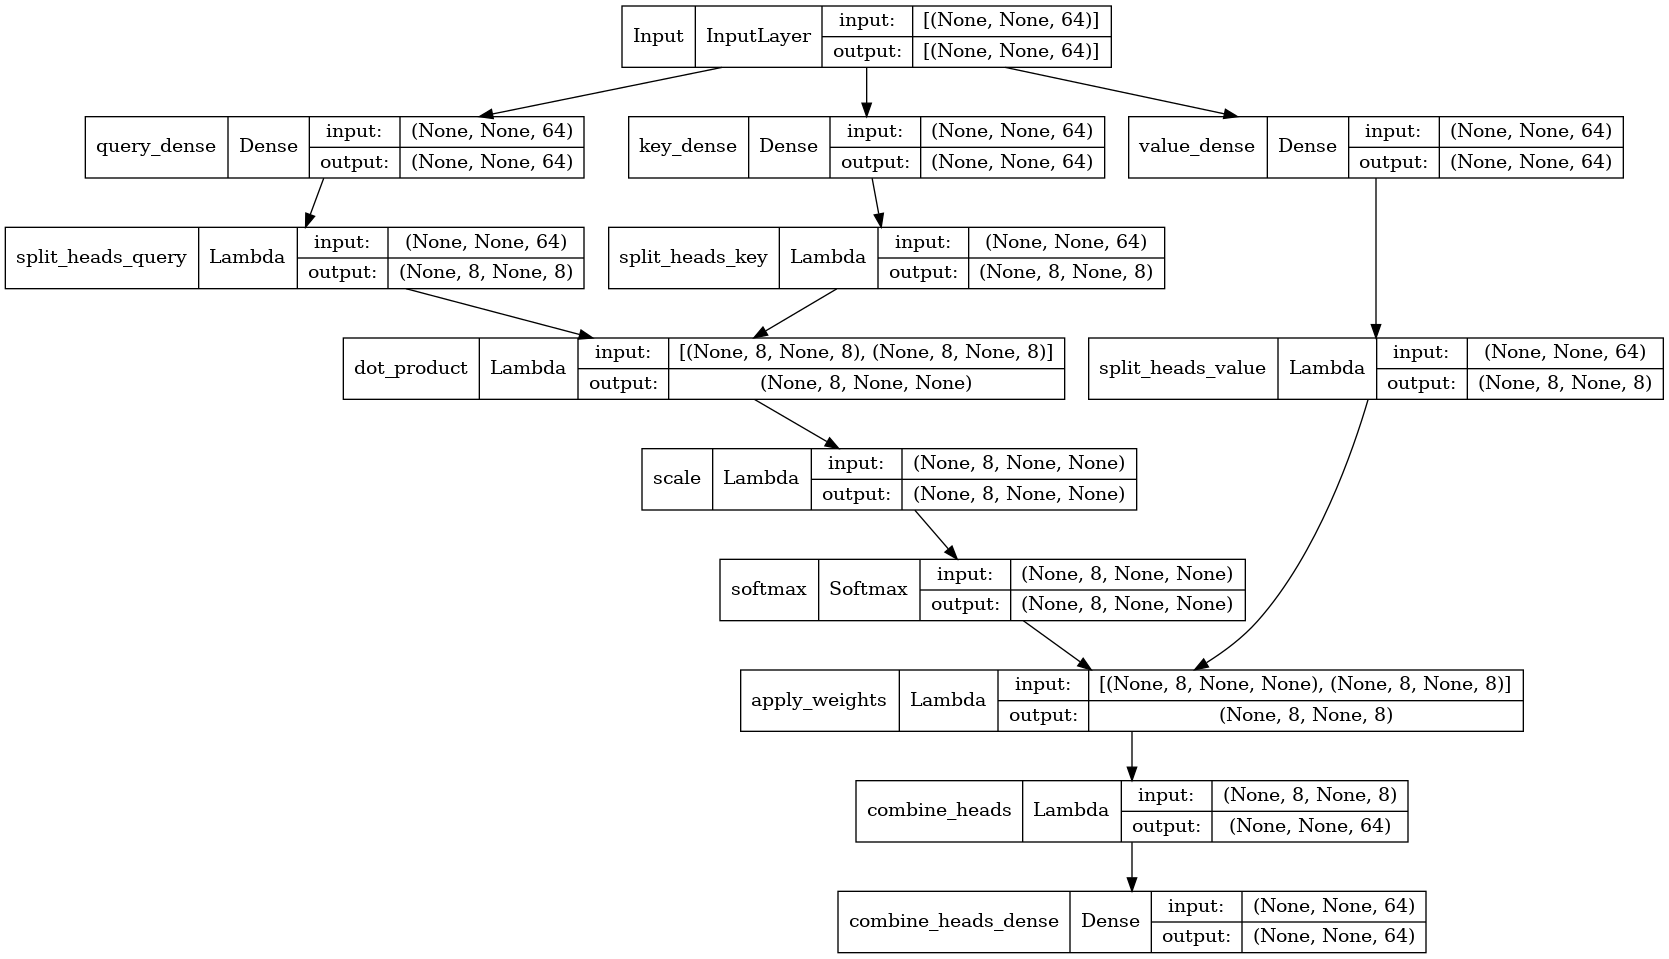

In [8]:
model = tf.keras.Model(inputs=input_tensor, outputs=output)
tf.keras.utils.plot_model(model, to_file="{}/mhsa_internal.png".format(outdir), show_shapes=True, show_layer_names=True, expand_nested=True)

An illustrative representation of the Multi-Head Self-Attention mechanism, detailing the splitting and processing of query, key, and value tensors through multiple attention heads.

In [9]:
dpi=300
plot_model_custom_dpi(model, os.path.join(outdir, 'mhsa_internal_hidef_{}.png'.format(dpi)), dpi=dpi)

The core equations for the Multi-Head Self-Attention are as follows:

1. First, the input \( $\mathbf{X}$ \) is transformed into Query, Key, and Value by matrix multiplication with three different weight matrices.

$$
\mathbf{Q}=\mathbf{X} \times { \mathbf{W} }_{ \text{Q} }
$$
$$
\mathbf{K}=\mathbf{X} \times { \mathbf{W} }_{ \text{K} }
$$
$$
\mathbf{V}=\mathbf{X} \times { \mathbf{W} }_{ \text{V} }
$$

2. Next, in the Attention mechanism, the dot product of \( $\mathbf{Q}$ \) and the transpose of \( $\mathbf{K}$ \) is computed. This result is then scaled by dividing by the square root of the dimension of \( $\mathbf{K}$ \). Applying the softmax function to this gives us the weights, which, when multiplied with \( $\mathbf{V}$ \), gives the final attention output.

$$
\text{Attention} (\mathbf{Q},\mathbf{K},\mathbf{V})= \text{softmax} \left( \frac { \mathbf{Q} { \mathbf{K} }^{ \top } }{ \sqrt { { d }_{ \text{K} } } } \right) \mathbf{V}
$$
